# Rice Image Classification using CNN
## Five different Rice Image Dataset: Arborio, Basmati, Ipsala, Jasmine, Karacadag
The dataset has 75K images including 15K pieces from each rice variety.<br>
Rice, which is among the most widely produced grain products worldwide, has many genetic varieties. These varieties are separated from each other due to some of their features. These are usually features such as texture, shape, and color. With these features that distinguish rice varieties, it is possible to classify and evaluate the quality of seeds. In this study, Arborio, Basmati, Ipsala, Jasmine and Karacadag, which are five different varieties of rice often grown in Turkey, were used.

For more information about the dataset use the following Kaggle link:<br>
https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset

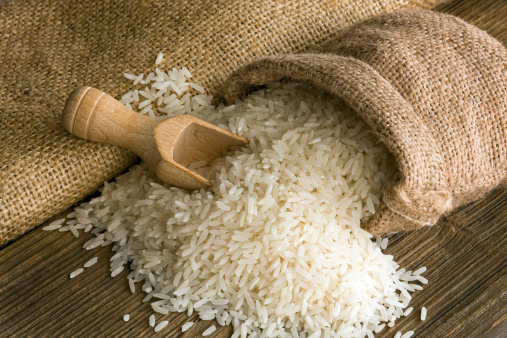

## Import Libraries and Load Data
After importing the needed libraries, we create a dataframe with the images and labels.

In [7]:
# import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the path to the dataset
dataset_path = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset'

# Initialize empty lists for storing the images and labels
images = []
labels = []

# Loop over the subfolders in the dataset
for subfolder in os.listdir(dataset_path):
  subfolder_path = os.path.join(dataset_path, subfolder)
  if not os.path.isdir(subfolder_path):
    continue
  
  # Loop over the images in the subfolder
  for image_filename in os.listdir(subfolder_path):
    # Load the image and store it in the images list
    image_path = os.path.join(subfolder_path, image_filename)
    images.append(image_path)
    
    # Store the label for the image in the labels list
    labels.append(subfolder)

# Create a pandas DataFrame from the images and labels
df = pd.DataFrame({'image': images, 'label': labels})

## EDA - Data Visualization

Let's see how our dataframe has come out.

In [8]:
df.head() # see dataframes first 5 entries

,image,label
0,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
1,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
2,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
3,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
4,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag


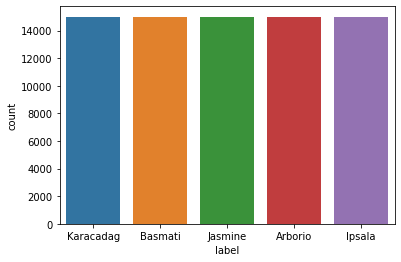

In [22]:
sns.countplot(x=df.label); # plot the classes

We can see that we have an even distribution of the rice types.<br>
Now let's show each rice class as images and see how the rice types are looking.

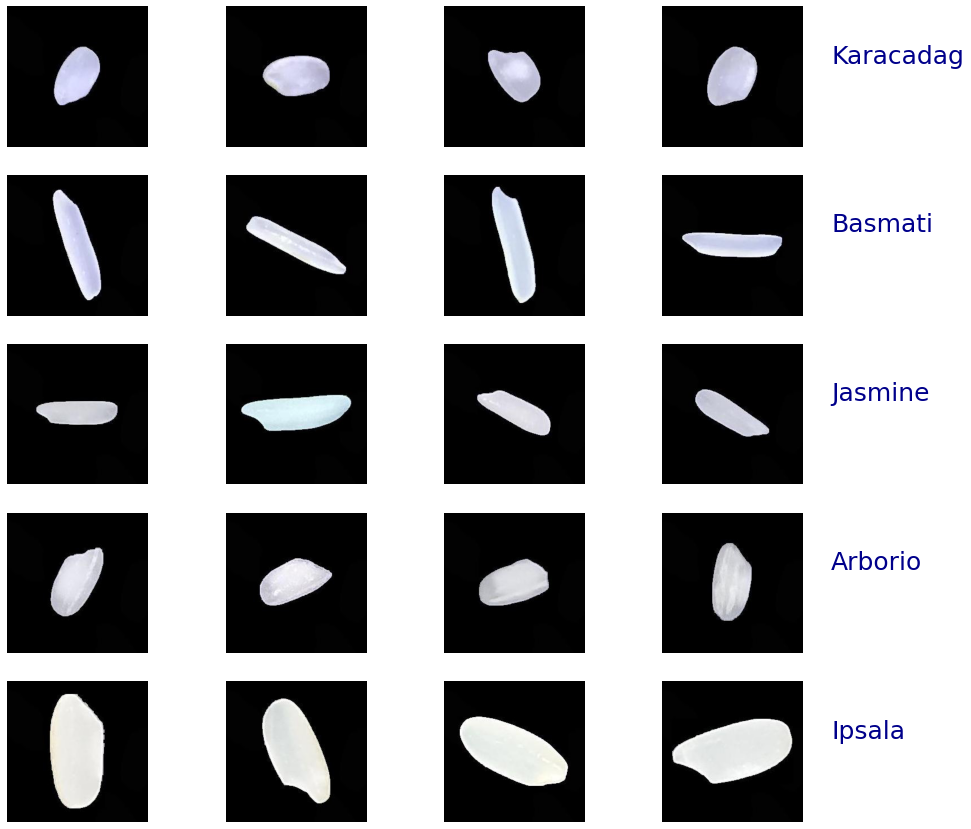

In [73]:
from matplotlib.gridspec import GridSpec

# Create figure and grid of subplots
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(5, 4, figure=fig)

# Loop through each unique category in the DataFrame
for i, category in enumerate(df['label'].unique()):
    # Get the filepaths for the first four images in the category
    filepaths = df[df['label'] == category]['image'].values[:4]
    
    # Loop through the filepaths and add an image to each subplot
    for j, filepath in enumerate(filepaths):
        ax = fig.add_subplot(gs[i, j])
        ax.imshow(plt.imread(filepath))
        ax.axis('off')
    
    # Add a label to the bottom of the subplot grid
    ax.text(300, 100, category, fontsize=25, color='darkblue')

plt.show()

## Split data into train and test dataframes + LabelEncoder
we split our data so we have train and test datasets. We use 80% for training and 20% for testing. Than we use the LabelEncoder on our labels which helps us to convert the labels for the types of rice (i.e., 'Arborio', 'Basmati', 'Ipsala', 'Jasmine', and 'Karacadag') into integer values that can be used as targets for training our machine learning model.

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['image'], df['label'], test_size=0.2, random_state=42)

# Create a dataframe for the training and testing data
df_train = pd.DataFrame({'image': X_train, 'label': y_train})
df_test = pd.DataFrame({'image': X_test, 'label': y_test})

# Encode the labels
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

## Creating Generators for the train and test data + Data Augmentation
We create generators for our train end test data and also apply data augmentation on our train set so we can easly preprocess our images. We reshape the images to 50x50.

In [13]:
from keras.preprocessing.image import ImageDataGenerator

# Set the image size and batch size
image_size = (50, 50)
batch_size = 32

# Create an ImageDataGenerator object with data augmentation options for image preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Create a generator for the training data
train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Create a generator for the test data
test_generator = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 60000 validated image filenames belonging to 5 classes.
Found 15000 validated image filenames belonging to 5 classes.


We can see that we have 60000 images for train and 15000 for test belonging to 5 classes.

## Modeling - CNN
We create a sequantial model with increasing filters and a softmax activation in the end. After compiling and fitting our model we evaluate the model on the test data and plot our results.

In [19]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
# Set the input shape for the model
input_shape = (50, 50, 3)

# Create a Sequential model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [20]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
# Train the model on the training data
history = model.fit_generator(train_generator,epochs=10,validation_data=test_generator)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-12-23 22:36:46.644832: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-12-23 22:36:48.623223: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1875/1875 [==============================] - 365s 190ms/step - loss: 0.3371 - accuracy: 0.8684 - val_loss: 0.1615 - val_accuracy: 0.9394
Epoch 2/10
1875/1875 [==============================] - 187s 100ms/step - loss: 0.1453 - accuracy: 0.9459 - val_loss: 0.0856 - val_accuracy: 0.9694
Epoch 3/10
1875/1875 [==============================] - 189s 101ms/step - loss: 0.1054 - accuracy: 0.9619 - val_loss: 0.0625 - val_accuracy: 0.9803
Epoch 4/10
1875/1875 [==============================] - 185s 99ms/step - loss: 0.0843 - accuracy: 0.9699 - val_loss: 0.0796 - val_accuracy: 0.9727
Epoch 5/10
1875/1875 [==============================] - 186s 99ms/step - loss: 0.0740 - accuracy: 0.9739 - val_loss: 0.0522 - val_accuracy: 0.9816
Epoch 6/10
1875/1875 [==============================] - 185s 99ms/step - loss: 0.0591 - accuracy: 0.9792 - val_loss: 0.0445 - val_accuracy: 0.9854
Epoch 7/10
1875/1875 [==============================] - 185s 99ms/step - loss: 0.0560 - accuracy: 0.9806 - val_loss: 0.0484 - 

In [23]:
# Evaluate the model on the test data
metrics = model.evaluate(test_generator)

469/469 [==============================] - 38s 81ms/step - loss: 0.0309 - accuracy: 0.9903


In [24]:
# Print the accuracy of the model
print('Accuracy:', metrics[1])

Accuracy: 0.9902666807174683


Our model achieved an **Accuracy of 99.03%.**

### Plot the Accuracy and Loss

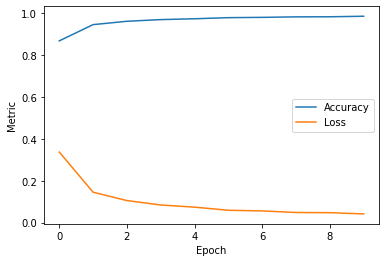

In [25]:
# Get the history of the model
history = history.history

# Plot the accuracy and loss of the model over time
plt.plot(history['accuracy'])
plt.plot(history['loss'])
plt.legend(['Accuracy', 'Loss'])
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.show()

P.S: For this project I had alot of help from ChatGPT. I tried to feed him information about the dataset and what my goals are. It could be because of my low knowledge but we had some issues at first. But after trying again and again, explaining more details and correcting some mistakes that it made, we came to a reasonable result (I think..:)). But I saw that you actually have to have at least some knowledge of the dataset and the code you are using to help ChatGPT achieve better results. We can't just simply only rely on its knowledge alone... yet.